## Final Capstone - Sentiment Analysis of Yelp Business Reviews </br>

Part II: Pre-process & Model

Biman Mondal

July 30, 2025

### Objective </br>

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The objective of the final capstone is to create several machine learning models which predict the sentiment of the customer reviews. Using some prebuilt sentiment analyzers like VADER and BERT, we will compare results ML classification models to pre-built models. The capstone's objective is to understand the nuance of performing natural language processing (NLP) and the various approaches to performing NLP tasks.</br>
</br>
This notebook finalizes the dataset and creates a model for comparison.
</span>

### Import Libraries

In [1]:
# Import numpy package
import numpy as np

# Import pandas package
import pandas as pd

# Import matplotlib package
import matplotlib.pyplot as plt
# Import the seaborn package
import seaborn as sns

# Import time
import time
# Import tqdm to monitor for loop progress
from tqdm import tqdm 
# Import operating system library
#
import re
import string
# Serialize Data
import pickle 
# Parallel processing
from multiprocessing import Pool, cpu_count

###############################################
# NLP IMPORTS
###############################################
# Import NLTK and all submodules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Import contractions
import contractions
# Import Spacy
import spacy
#
# Import Counter
from collections import Counter

#Term frequency vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Transformers pipeline
from transformers import pipeline

###############################################
# ML IMPORTS
###############################################
# Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
# ML Models
from sklearn.linear_model import LogisticRegression
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
# Support Vector Machines
from sklearn.svm import LinearSVC
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Get accuracy score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

Disabling PyTorch because PyTorch >= 2.1 is required but found 1.12.1


In [ ]:
#!pip install -q transformers
#!pip uninstall numpy
#!pip install --user numpy==1.8
#print(np.__version__)
#nltk.download('vader_lexicon') # one time only

### Read dataframe
<strong> About the dataframe:</strong></br>
The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data.\
http://www.yelp.com/dataset_challenge </br>
The dataset is sourced from hugging face.</br>
https://huggingface.co/datasets/Yelp/yelp_review_full</br>
The dataset consists of two .csv files: training.csv with 650k records and test.csv. with 50k records.</br>

<strong> Assume:</strong> </br>
<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
As seen in the previous data wrangling / exploratory data analysis notebook, the star ratings are equally distributed in the dataframe. In order to model the dataset (1,2) stars are categorized as "negative" / -1, while (3) stars is "neutral" / 0 and (4,5) stars are categorized as "positive" / 1. 
</span>

In [4]:
# Read Training Dataframe
df = pd.read_csv('../data/raw/yelp_review_fine-grained_5_classes_csv/train.csv', header='infer')
df.head()

,class_index,review_text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [11]:
# Read Test Reviews Dataframe
df_test = pd.read_csv('../data/raw/yelp_review_fine-grained_5_classes_csv/test.csv', header='infer')
#print("Shape of dataset: ", df_test.shape)
#print(df_test.class_index.value_counts())
df_test.head()

,class_index,review_text
0,1,I got 'new' tires from them and within two wee...
1,1,Don't waste your time. We had two different p...
2,1,All I can say is the worst! We were the only 2...
3,1,I have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...


## Text Normalization</br>

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Continue from previous notebook to process the review text.</br>
Normalization is the process that brings words into standard format.
    Stemming reduces words to their root form by chopping off suffixes (running -> run) however may lead to non-valid words (organization -> organizat).</br>
    Lemmatization is the process of reducing inflected forms of a word to its lemma, or base form, as found in a dictionary.
</span>
</br>
<span style="color: red; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Processing the entire dataframe of 650k records half an hour using the following script.
For expediency, the pickled file format of the processed dataframe were saved locally and read subsequently. 
</span>

In [57]:
def process_text(text_list):
    start = time.time()
    # Remove contractions and stop words
    processed_text = list()
    # Add stop words
    stop_words = stopwords.words('english')
    stop_words.extend(["would", "could","should","go","going","get",\
                       "got","told","also","come","us","said","asked",\
                       "even","back","really","place","'ve","n't","'m",\
                        "people", "place","food","try","went","say",\
                       "took","take","time","way","like","ever","never",\
                       "'s","'ll","'d","w/","one","two","three","four"])
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # For loop to process each review
    for text in tqdm(text_list):
        # Tokenize the lowered text and fix contractions
        tokens = word_tokenize(text.lower())
        # Remove stop words and punctuations in the tokens list
        filtered_tokens = [token for token in tokens 
                   if token not in stop_words
                   and token not in string.punctuation
                   and token.isalpha()
                   and token != "''"
                   and not re.search(r"\.{2,}", token)
                   and not re.search(r'\-{2,}', token)
                   and not re.search(r'\\', token)]
        
        # Lemmatized tokens
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        # Join lemmatized tokens
        lemmatized_text = ' '.join(lemmatized_tokens)
        # Add to token list to be counted
        processed_text.append(lemmatized_text)
    
    end = time.time()
    print(f"Time elapsed: {round((end - start)/60,1)} min")
    return processed_text


# Pre-process text of dataframe
#sample_df = df.sample(frac=0.1)
#sample_df = df.sample(n=5000, random_state=9)
#processed_text = process_text(sample_df['review_text'].values.tolist(), nlp)

# Train dataset takes 30 min to process
"""
# Pre-process entire train dataset
df["processed_text"] = process_text(df['review_text'].values.tolist())

# Save processed train dataset
file_name = 'train_dataset_processed.pkl'
with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(df, f) # serialize the list
f.close()
"""
# Test dataset takes 5 min to process
"""
# Pre-process entire test dataset
df_test["processed_text"] = process_text(df_test['review_text'].values.tolist())

# Save processed test dataset
file_name = 'test_dataset_processed.pkl'
with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(df_test, f) # serialize the list
f.close()
"""

100%|█████████████████████████████████████████████████████████████████████████| 650000/650000 [30:22<00:00, 356.63it/s]


Time elapsed: 30.4 min


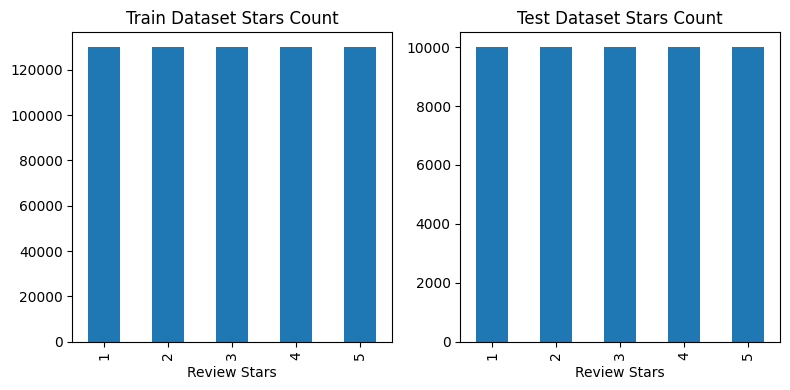

In [15]:
# Plot bar graph of the Review Stars
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
df['class_index'].value_counts().sort_index() \
                .plot(kind='bar',
                title='Train Dataset Stars Count',ax=axes[0])
axes[0].set_xlabel('Review Stars')

axes[1] = df_test['class_index'].value_counts().sort_index() \
            .plot(kind='bar',
            title='Test Dataset Stars Count',ax=axes[1])
axes[1].set_xlabel('Review Stars')

plt.tight_layout()
plt.show()

### Save / Read Pickled Data

In [8]:
# Save data
'''
# Save data
file_name = 'processed_text.pkl'

with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(processed_text, f) # serialize the list
f.close()

# Read Train Data
with open('train_dataset_processed.pkl', 'rb') as f:
    dftrain_processed = pickle.load(f) # deserialize using load()
    
# Read Train Data
with open('test_dataset_processed.pkl', 'rb') as f:
    dftest_processed = pickle.load(f) # deserialize using load()
'''
# Apply map function to dataframe column
#dftest_processed['star_sentiment'] = dftest_processed['class_index']\
#                                .map(lambda x: mapfunc(x))
#df_processed = df_processed.iloc[:,[0,4,1,2,3,5]]
#train_df_processed.head()

### Sentiment Analysis using NLTK VADER

In [11]:
def get_sentiment(text_list):
    start = time.time()
    # Determine the sentiment of entire training set
    analyzer = SentimentIntensityAnalyzer()    
        
    sent_results = list()
    # Loop through dataframe processed text to get sentiment
    for text in tqdm(text_list):
        # Get the sentiment polarity from text
        scores = analyzer.polarity_scores(text)
        # Condition for sentiment results
        if scores['compound'] > 0.75:
            sentiment = 'positive'
        elif scores['compound'] <-0.75:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'
        # Create list of sentiment
        sent_results.append(sentiment)
        
    end = time.time()
    print(f"Time elapsed: {round((end - start)/60,1)} min")
    return sent_results

# Convert sentiment to numerical value
def mapfunc(x):
    output = None
    if x=="negative":
        output = -1
    elif x=="neutral":
        output = 0
    elif x=="positive":
        output = 1
    return output

# Get VADER sentiment train dataset
dftrain_processed['sentiment'] = get_sentiment(dftrain_processed\
                                               .processed_text.to_list())

# Apply map function
dftrain_processed['num_sentiment'] = dftrain_processed['sentiment']\
                                            .map(lambda x: mapfunc(x))

# Get VADER sentiment test dataset
dftest_processed['sentiment'] = get_sentiment(dftest_processed\
                                          .processed_text.to_list())

# Apply map function
dftest_processed['num_sentiment'] = dftest_processed['sentiment']\
                                        .map(lambda x: mapfunc(x))

100%|█████████████████████████████████████████████████| 650000/650000 [13:24<00:00, 807.75it/s]


Time elapsed: 13.4 min


100%|███████████████████████████████████████████████████| 50000/50000 [00:56<00:00, 877.52it/s]


Time elapsed: 0.9 min


"\ndftrain_processed.processed_text.to_list()\n\n\n\n\n\n# Combine results with df\ndftrain_processed['sentiment'] = [val[1] for val in sent_results]\n\n\n\n\n\n# Save dataframe with results as pickled data\nfile_name = 'train_dataset_processed_NLTKsentiment.pkl'\nwith open(file_name, 'wb') as f:  # open a text file\n    pickle.dump(df_processed, f) # serialize the list\nf.close()\n\n"

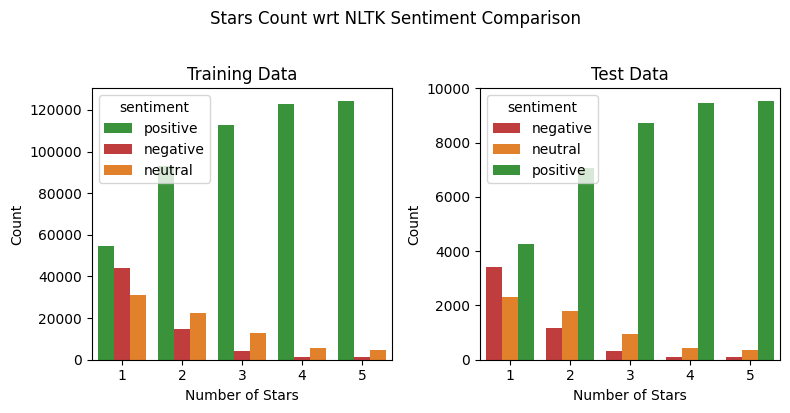

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sentiment_colors = {'positive': '#2ca02c', 'negative': '#d62728', 'neutral': '#ff7f0e'}

# Plot categorical of sentiment with 
sns.countplot(x='class_index',data=dftrain_processed,
                ax=axes[0], hue='sentiment',palette=sentiment_colors)

axes[0].set_title('Training Data')
axes[0].set_xlabel('Number of Stars')
axes[0].set_ylabel('Count')
sns.countplot(x='class_index', data=dftest_processed,
                  ax=axes[1], hue='sentiment',palette=sentiment_colors)

axes[1].set_title('Test Data')
axes[1].set_xlabel('Number of Stars')
axes[1].set_ylabel('Count')

fig.suptitle('Stars Count wrt NLTK Sentiment Comparison', y=1.02)
plt.tight_layout()
plt.show()

### Convert Star Reviews to Numerical Sentiment

In [14]:
## Converting the star rating system converted to "positive", "negative" and "neutral" leads to an imbalanced dataset.
# Convert Star value to numerical sentiment
# [1,2] stars == 'negative' == -1
# 3 stars == "neutral" == 0
# 4 stars == "positive" == 1
def mapfunc(x):
    output = None
    if x==1 or x==2:
        output = -1
    elif x==3:
        output = 0
    elif x==4 or x==5:
        output = 1
    return output

# Apply map function to dataframe column
dftrain_processed['star_sentiment'] = dftrain_processed['class_index']\
                                                .map(lambda x: mapfunc(x))
#reorder columns
dftrain_processed = dftrain_processed.iloc[:,[0,5,1,2,3,4]]

# Apply map function to dataframe column
dftest_processed['star_sentiment'] = dftest_processed['class_index']\
                                            .map(lambda x: mapfunc(x))
#reorder columns
dftest_processed = dftest_processed.iloc[:,[0,5,1,2,3,4]]

In [41]:
'''
# Save dataframe with results as pickled data
with open('train_dataset_processed_NLTKsentiment.pkl', 'wb') as f:  # open a text file
    pickle.dump(dftrain_processed, f) # serialize the list
f.close()

with open('test_dataset_processed_NLTKsentiment.pkl', 'wb') as f:  # open a text file
    pickle.dump(dftest_processed, f) # serialize the list
f.close()
'''

# Read Train Data
with open('train_dataset_processed_NLTKsentiment.pkl', 'rb') as f:
    dftrain_processed = pickle.load(f) # deserialize using load()

# Read Test Data
with open('test_dataset_processed_NLTKsentiment.pkl', 'rb') as f:
    dftest_processed = pickle.load(f) # deserialize using load()

### Create TFDIF Features and Split Dataset

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The following script takes half an hour to run through the entire dataset.

In [42]:
start = time.time()

# TFIDF vectorizer
train_vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.99)

# Fit transform
train_tfidf = train_vectorizer.fit_transform(dftrain_processed.processed_text)
print("TFIDF sparse matrix size:\n", train_tfidf.shape)

# Fit transform
test_tfidf = train_vectorizer.transform(dftest_processed.processed_text)
print("TFIDF sparse matrix size:\n", test_tfidf.shape)

## Set X as the TF-IDF transformed matrix
X_train = train_tfidf
## Set Y as the number of stars
y_train = dftrain_processed.star_sentiment

X_test = test_tfidf
y_test = dftest_processed.star_sentiment

'''
# Split data 70% train / 30% test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                   test_size= 0.3, random_state= 9)
''' 
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

TFIDF sparse matrix size:
 (650000, 953)
TFIDF sparse matrix size:
 (50000, 953)
Time elapsed: 0.8 min


## Multinomial Classification Models

[{'Max_Accuracy': 0.7146307692307692,
  'Mean_Accuracy': 0.7127738461538462,
  'Min_Accuracy': 0.7113461538461539,
  'Model': 'Logistic Regression',
  'Std_Accuracy': 0.0011708753616102752},
 {'Max_Accuracy': 0.6978692307692308,
  'Mean_Accuracy': 0.697036923076923,
  'Min_Accuracy': 0.6954615384615385,
  'Model': 'Naive Bayes',
  'Std_Accuracy': 0.0008217084237902202},
 {'Max_Accuracy': 0.7390461538461538,
  'Mean_Accuracy': 0.7382446153846154,
  'Min_Accuracy': 0.7377076923076923,
  'Model': 'SVC',
  'Std_Accuracy': 0.0005887786978394865},
 {'Max_Accuracy': 0.6367769230769231,
  'Mean_Accuracy': 0.632436923076923,
  'Min_Accuracy': 0.6277,
  'Model': 'Random Forest',
  'Std_Accuracy': 0.0035000875728689283}]

Elapsed time: 2.507 minutes.


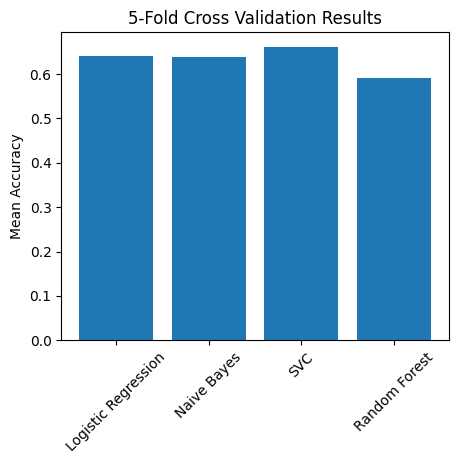

In [44]:
#
start_time = time.perf_counter()

def get_model():
    model = []
    log_model = LogisticRegression(C=0.01, class_weight = {-1:0.833, 0:1.667, 1:0.833})
    nb_model = MultinomialNB(class_prior=[0.4, 0.2, 0.4])
    svc_model = LinearSVC(class_weight = {-1:0.833, 0:1.667, 1:0.833})
    rf_model = RandomForestClassifier(class_weight = {-1:0.833, 0:1.667, 1:0.833}, max_depth=3)
    gb_model = GradientBoostingClassifier(max_depth=1)
    
    model = {
        'Logistic Regression': log_model, 
        'Naive Bayes': nb_model,
        'SVC': svc_model,
        'Random Forest': rf_model
        }
    return model

# Cross Validation
def evaluate_model(X,y,cv):
    # get the model
    models = get_model()
    results = []
    # Loop through the models to get cross validation scores
    for name, model in models.items():
        # evaluate the model
        scores = cross_val_score(model, X, y,scoring='accuracy',\
                                 cv=cv, n_jobs=-1)
        results.append({
            'Model': name,
            'Mean_Accuracy': scores.mean(),
            'Std_Accuracy': scores.std(),
            'Min_Accuracy': scores.min(),
            'Max_Accuracy': scores.max()
            })
    # return scores
    return results

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Get results
cv_results =  evaluate_model(X_train, y_train, cv=cv)

import pprint
pprint.pprint(cv_results)
#
end_time = time.perf_counter()
print(f"\nElapsed time: {round((end_time - start_time)/60,3)} minutes.")

# Plot the results
model, result = list(), list()
for val in res:
    model.append(val['Model'])
    result.append(val["Mean_Accuracy"])

fig, ax = plt.subplots(figsize=(5, 4))
plt.bar(x=model, height=result)
ax.set_title("5-Fold Cross Validation Results")
ax.set_ylabel("Mean Accuracy")
ax.tick_params(axis='x', labelrotation=45)
plt.show()

### Log Regression

LogisticRegression(C=0.01, class_weight={-1: 0.833, 0: 1.667, 1: 0.833})
              precision    recall  f1-score   support

          -1       0.81      0.76      0.78     20000
           0       0.44      0.59      0.50     10000
           1       0.83      0.74      0.78     20000

    accuracy                           0.72     50000
   macro avg       0.69      0.70      0.69     50000
weighted avg       0.74      0.72      0.73     50000



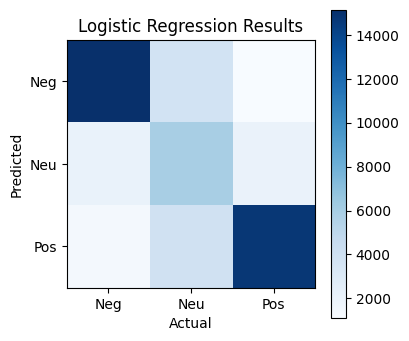

Time elapsed: 0.3 min


In [98]:
start = time.time()
# Set regularization rate
reg = 100
# train a logistic regression model on the training set
log_model = LogisticRegression(C=1/reg, class_weight = \
                               {-1:0.833, 0:1.667, 1:0.833}).fit(X_train, y_train)
print(log_model)

X_test = test_tfidf
y_test = dftest_processed.star_sentiment

# Determine prediction
log_pred = log_model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, log_pred))

# Confusion matrix
mcm_log = confusion_matrix(y_test, log_pred)
#print(mcm_log)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_log, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Logistic Regression Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

### Naive Bayes Model

MultinomialNB(class_prior=[0.4, 0.2, 0.4])
              precision    recall  f1-score   support

          -1       0.72      0.84      0.77     20000
           0       0.56      0.09      0.15     10000
           1       0.69      0.86      0.76     20000

    accuracy                           0.70     50000
   macro avg       0.65      0.60      0.56     50000
weighted avg       0.67      0.70      0.64     50000



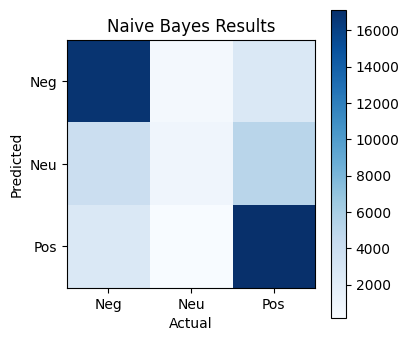

Time elapsed: 0.0 min


In [46]:
start = time.time()

nb_model = MultinomialNB(class_prior=[0.4, 0.2, 0.4])\
                                .fit(X_train, y_train)
                        
print(nb_model)
nb_y_pred = nb_model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, nb_y_pred))

# Confusion matrix
mcm_nb = confusion_matrix(y_test, nb_y_pred)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_nb, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Naive Bayes Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

### Support Vector Machine Model

LinearSVC(class_weight={-1: 0.833, 0: 1.667, 1: 0.833})
              precision    recall  f1-score   support

          -1       0.79      0.82      0.80     20000
           0       0.50      0.41      0.45     10000
           1       0.79      0.82      0.80     20000

    accuracy                           0.74     50000
   macro avg       0.69      0.68      0.69     50000
weighted avg       0.73      0.74      0.73     50000



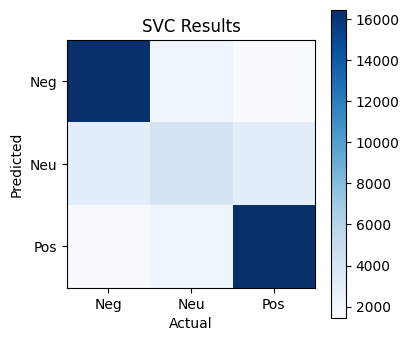

Time elapsed: 0.4 min


In [48]:
start = time.time()

svc_model = LinearSVC(class_weight = {-1:0.833, 0:1.667, 1:0.833})\
                                    .fit(X_train, y_train)
print(svc_model)
svc_y_pred = svc_model.predict(X_test)
# Print Classification Report
print(classification_report(y_test, svc_y_pred))

# Confusion matrix
mcm_svc = confusion_matrix(y_test, svc_y_pred)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_svc, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('SVC Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

### Random Forest Classfier

RandomForestClassifier(class_weight={-1: 0.833, 0: 1.667, 1: 0.833},
                       max_depth=3, random_state=9)
              precision    recall  f1-score   support

          -1       0.64      0.67      0.66     20000
           0       0.34      0.42      0.37     10000
           1       0.70      0.60      0.64     20000

    accuracy                           0.59     50000
   macro avg       0.56      0.56      0.56     50000
weighted avg       0.60      0.59      0.59     50000



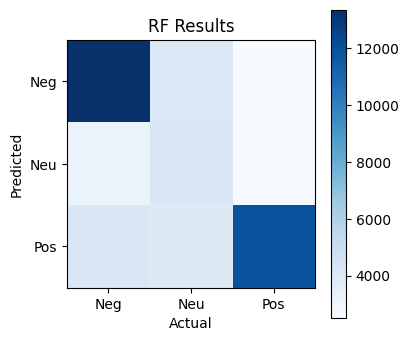

Time elapsed: 1.3 min


In [80]:
start = time.time()
# Random Forest Classifier
rf_model = RandomForestClassifier(class_weight = {-1:0.833, 0:1.667, 1:0.833},
                                  n_estimators=100,max_depth=3,
                                  random_state=9)\
                                 .fit(X_train, y_train)
print(rf_model)

# Prediction
rf_y_pred = rf_model.predict(X_test)
# Print Classification Report
print(classification_report(y_test, rf_y_pred))
# Calculate confusion matrix
mcm_rf = confusion_matrix(y_test, rf_y_pred)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_rf, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('RF Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

### VADER Sentiment Results

              precision    recall  f1-score   support

          -1       0.89      0.23      0.36    260000
           0       0.17      0.10      0.13    130000
           1       0.49      0.95      0.64    260000

    accuracy                           0.49    650000
   macro avg       0.52      0.43      0.38    650000
weighted avg       0.59      0.49      0.43    650000



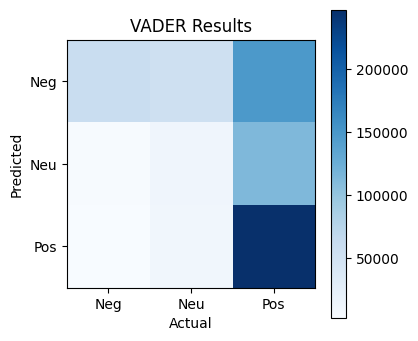

In [79]:
# Compare actual star sentiment vs. predicted sentiment from VADER
# Print Classification Report
print(classification_report(dftrain_processed['star_sentiment'], dftrain_processed['num_sentiment']))

# Confusion matrix
mcm_sent = confusion_matrix(dftrain_processed['star_sentiment'], dftrain_processed['num_sentiment'])
# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_sent, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('VADER Results')
plt.show()


## Model Accuracy Score Comparison

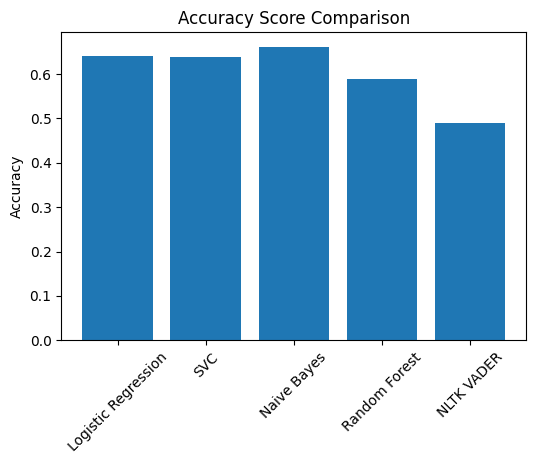

In [91]:

acc_models = ['Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest', 'NLTK VADER']
acc_scores = [accuracy_score(y_test, log_pred),
                accuracy_score(y_test, nb_y_pred),
                accuracy_score(y_test, svc_y_pred),
                accuracy_score(y_test, rf_y_pred),
                accuracy_score(dftrain_processed['star_sentiment'], dftrain_processed['num_sentiment'])]
# Plot bar graph
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x=acc_models, height=acc_scores)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Accuracy Score Comparison')
ax.set_ylabel('Accuracy')
plt.show()

## Summary</br>

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
This notebook outlines the operations to perform sentiment analysis using a yelp review dataset. The training set comprised of 650k reviews and the test set is comprised of 50k reviews. A preprocessing function was used to transform the reviews by removing stop words, removing extraneous characters with regular expressions, and lemmatizing tokens to their roots. Processing both datasets takes a significant amount of time, nearly an hour hours. The dataset was written to a local binary file (pickled) to prevent having process the dataset each time to run the notebook. </br>

An assumption was made that (1,2) stars are a negative sentiment, a 3 stars equated to a neutral sentiment, and (4,5) stars are a positive sentiment. The processed reviews were then vectorized to create features using TF-IDF. This process yielded a sparse matrix of features to model against the star review ratings. The initial dataset included a equal distribution of number of stars (classes).  

The dataset was split 70% train / 30% test for modeling. Log-regression, SVM, Naive Bayes, and Random Forest multinomial classification models were used to make sentiment prediction. The stars to sentiment conversion, yields an imbalanced set where 'neutral' is 3 stars where 'positive' is both (4,5) stars. A class weighting was supplied to the models to account for the class imbalance.Comparing accuracy results show a Naive Bayes performed the best.

NLTK 'SentimentIntensityAnalyzer' which uses the Valence Aware Dictionary and Sentiment Reasoner (VADER) was used to perform sentiment analysis on the processed reviews. This model is a 'black box' model that operates on the processed reviews. The VADER model applied to the actual text performed the worst on predicting sentinment. 